# Chapter 26 - Nonlinear Regression Models

### Steve Elston

Up to now, we have only worked with Normally distributed **numeric response variables**. However, **nonlinear response variables** are extremely common. For example, **categorical responses** and responses of counts from **point processes** .     

In this notebook you will be introduced to working with models with nonlinear response variable. Specifically, you will work with the **generalized linear model (GLM)**. The GLM transforms a nonlinear response to a linear, or Normally distributed response using a **link function**. Link functions exist for any response distribution which can be written in exponential form.        

We solve the nonlinear problem by creating a solution to a linear model. The nonlinear response is then computed using the **inverse link function**.       

## Preparing the Data Set

In this section we will prepare the data set used in this notebook. These data were compiled from credit data for German bank customers, and are from the [University of California Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data). The objective is to build a model to predict customer credit quality, [good,bad], using the variable provided. This is a notoriously difficult problem.    

> **Exercise 26-1:** The data sampled is based on the outcome of customers fulfilling their repayment obligations on loans. However, as is typically the case, we have no information on how perspective customers turned down for loads would have performed, which are **unobservable**. Write a few sentences discussing how any model fitted with these data could lead to biased credit decisions.    

As a first step, execute the code in the cell below to import the required packages.

In [14]:
import pandas as pd
import numpy as np
import numpy.random as nr
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as ss
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import sklearn.metrics as sklm
from patsy import dmatrices

%matplotlib inline

C:\USERS\STEVEPC2\ANACONDA3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Execute the cell below to display the dimensions of the data frame and display the data types of the columns. 

In [15]:
credit_data = pd.read_csv('../data/German_Credit_Clean.csv')
print(credit_data.shape)
credit_data.dtypes

(1000, 22)


customer_id                  int64
checking_account_status     object
loan_duration_mo             int64
credit_history              object
purpose                     object
loan_amount                  int64
savings_account_balance     object
time_employed_yrs           object
payment_pcnt_income          int64
gender_status               object
other_signators             object
time_in_residence            int64
property                    object
age_yrs                      int64
other_credit_outstanding    object
home_ownership              object
number_loans                 int64
job_category                object
dependents                   int64
telephone                   object
foreign_worker              object
bad_credit                   int64
dtype: object

There are a number of numeric and categorical predictor variables. The label is binary with values $[0,1]$, of type 'int64'. We will discuss the properties of this label further shortly.  

One difficulty with this data set is that there is an **imbalance** between the negative cases and the positive cases.

In [16]:
np.sum(credit_data.loc[:,'bad_credit'])

300

THe number of positive cases is only 30% of all cases. This imbalance will bias the training of any model toward the negative cases.

Now, we will prepare training and test data sets with normalized numeric features (predictor variables). Execute this code to create Bernoulli sampled training and test data sets. 

In [17]:
num_cols = ['loan_duration_mo','loan_amount','payment_pcnt_income','age_yrs']
credit_data.loc[:,num_cols] = normalize(credit_data.loc[:,num_cols])

## Create a mask and use it to split the data into a train and test set   
nr.seed(6665)
mask = nr.choice(credit_data.index, size = 600, replace=False)
credit_data_train = credit_data.iloc[mask,:]
credit_data_test = credit_data.drop(mask, axis=0) 

## Logistic Regression

Until now, we have been working strictly with linear regression models. Linear regression models have a numeric label. Further, ordinary linear regression assumes the label values are Normally distributed. 

But, what if the label has another distribution, particularly if the label is categorical? Using a more general form for the label values leads us to the **generalized linear model**. Generalized linear model can use a number of distributions for the label .   

Here, we will look at a widely used variation of the generalized linear model using a **Binomial distribution**. This method is commonly known as **logistic regression**.

Logistic regression is widely used as a classification model. Logistic regression is linear model, with a binary response or label values, `{False, True}` or `{0, 1}`.  specifically, the response is computed as a log likelihood, leading to a Binomial distribution of the label values. 

The response of the linear model is transformed to the log likelihood using a sigmoidal function, also know as the **logistic function** or **logit**:

$$f(x) = \frac{1}{1 + e^{-\kappa(x - x_0)}} \\
\kappa = steepness$$

Execute the code in the cell below to compute and plot an example of the logistic function.

C:\USERS\STEVEPC2\ANACONDA3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


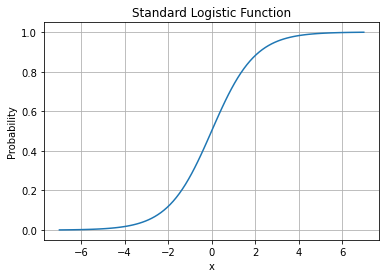

In [18]:
# Plot the logistic transformation function (f(x) above)
x_seq = np.linspace(-7, 7, 100)

def log_fun(x, center=0, scale=1):
    e = np.exp(scale*(center-x))
    log_out = 1./(1. + e)
    return log_out

log_fun_vectorized = np.vectorize(log_fun)

log_y = log_fun_vectorized(x_seq)

plt.plot(x_seq, log_y)
plt.title('Standard Logistic Function')
plt.xlabel('x')
plt.ylabel('Probability')
plt.grid()

Let's make this a bit more concrete with a simple example. Say we have a linear model:

$$\hat{y} = \beta_0 + \beta_1\ x$$

Now, depending on the value of $\hat{y}$ we want to classify the output from a logistic regression model as either `0` or `1`. We can use the linear model in the logistic function as follows:

$$F(\hat{y}) = \frac{1}{1 + e^{-\kappa(\beta_0 + \beta_1\ x)}} $$

In this way we transform the continious output of the linear model defined on $-\infty \le \hat{y} \le \infty$ to a binary response, $0 \le F(\hat{y}) \le 1$

The aforementioned function maps the output of a linear model to the response values of the label. This function is known as the **link function**, since it links the linear response to the label values.  

### What is Deviance?

The significance of the GLM is expressed in terms of something called **deviance**. It can be a bit of a challenge to wrap your head around what deviance really means. It turns out that you already know one form of deviance. The familiar mean squared error of a model with Normally distributed residuals is the deviance of this model.  

For the model above the residuals would be Binomially distributed. We need a more general formulation of deviance for such a model. For a model with label vector $y$, predictions$\hat{\mu}$, and estimated model parameters, $\hat{\theta}$ the general form of deviance can be written:

\begin{align}
D(y,\hat{\mu}) &= 2 \Big( log \big( p(y | \hat{\theta}_{S}) \big) - log \big( p(y | \hat{\theta}_{0}) \big) \Big) \\
&= 2 \Big( \mathcal{l}(y | \hat{\theta}_{S})  -  \mathcal{l}(y | \hat{\theta}_{0})  \Big)
\end{align}

where,    
- $\mathcal{l}(y | \hat{\theta}) \big)$ is the log likelihood of a model with estimated parameters, $\hat{\theta}$, given labels $y$.    
- $\hat{\theta}_{S}$ are the estimated parameters of a **saturated**; a hypothetical model, $M_S$, with a parameter for each observation, and therefore having the best possible fit to the training data.   
- $\hat{\theta}_{0}$ are the actual estimated parameters of the model, $M_0$, that we wish to evaluate.   

This all seems rather abstract. In particular, what use is this hypothetical saturated model? 

Fortunately, we can use the **deviance ratio** to compare models in a form we can actually work with. The trick is to recognize that the log likelihood of the saturated model, $\mathcal{l}(y | \hat{\theta}_{0})$, is just a constant. With this insight we can rewrite the deviance as:

$$D(y,\hat{\mu}) = Constant + 2 \mathcal{l}(y | \hat{\theta}_{0})$$

This looks a bit better! Now we can work with the deviance ratio to compare two models, $M_1$ and $M_0$:   

\begin{align}
D(\hat{\theta}_1,\hat{\theta}_0) &= \frac{Constant + 2 \mathcal{l}(y | \hat{\theta}_{0})}{Constant + 2 \mathcal{l}(y | \hat{\theta}_{1})} \\ 
&= Constant + 2 \mathcal{l}(y | \hat{\theta}_{0}) - Constant - 2 \mathcal{l}(y | \hat{\theta}_{1}) \\
&= 2 \mathcal{l}(y | \hat{\theta}_{0}) - 2 \mathcal{l}(y | \hat{\theta}_{1})
\end{align}

Which model should we use as a comparison in the above relation? The **null model** is a good choice. The null model is just a model that makes predictions based on the expected value of mean. This formulation is called the **null deviance**, and is what is typically displayed by most statistical software packages, including statsmodels. Unfortunately, this quantity is usually just called, deviance, even when it is actually null deviance, something rather different.   

A nice property of null deviance is that for large number of samples (approaching infinity), it is Chi Squared distributed. Thus, we can test the statistical significance of the model against the null model using the Chi Squared test. Since the derivation of this test depends on something called Wilk's theorem, this is often referred to as **Wilk's test**. 

The null deviance is also useful for comparing models. If you have two models and want to know which is better, pick the one with the maximum null deviance.  

## Classification Example

To make these concepts concrete we will now build and test a classification model with Binomial response. To understand the features and labels of this model it will be useful to look at the model matrix and the label column. Execute the code in the cell below to display the head of the label array and the model matrix. 

In [19]:
formula = 'bad_credit ~ C(credit_history) + C(purpose) + C(gender_status) + C(time_employed_yrs) +C(other_credit_outstanding)\
           + C(property) + C(job_category) + loan_duration_mo + payment_pcnt_income + age_yrs'
Y, X = dmatrices(formula, data=credit_data_train)
print(Y[:5])
print(X[:2])

[[1.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[1.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 6.18296711e-03 5.15247259e-04 5.41009622e-03]
 [1.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00 2.01465451e-03 3.3577

C:\USERS\STEVEPC2\ANACONDA3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The label array is binary with values $[0,1$. This response is must be Binomially distributed making this a nonlinear response problem.  

The feature (design) matrix is not surprising. The first column contains the intercept term of all 1s. The categorical feature columns are all one-hot encoded. The last three columns are the normalized values of the numeric features. 

The statsmodels [GLM](https://www.statsmodels.org/stable/examples/notebooks/generated/glm.html) function implements the [generalize linear model](https://www.statsmodels.org/stable/glm.html#families) for a number of response distributions. The code in the cell below uses the Binomial family as the distribution of the label. Execute this code and examine the model summary. 

In [20]:
nr.seed(4536)
glm_model = smf.glm(formula, data=credit_data_train, family=sm.families.Binomial()).fit()
glm_model.summary()

C:\USERS\STEVEPC2\ANACONDA3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             bad_credit   No. Observations:                  600
Model:                            GLM   Df Residuals:                      568
Model Family:                Binomial   Df Model:                           31
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -294.08
Date:                Mon, 05 Apr 2021   Deviance:                       588.16
Time:                        13:39:23   Pearson chi2:                     579.
No. Iterations:                    21                                         
Covariance Type:            nonrobust                                         
================================================================================================================================
                                                                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        0.5382      0.708      0.760      0.447      -0.850       1.927
C(credit_history)[T.critical account - other non-bank loans]    -1.7193      0.491     -3.504      0.000      -2.681      -0.758
C(credit_history)[T.current loans paid]                         -1.0366      0.459     -2.258      0.024      -1.936      -0.137
C(credit_history)[T.no credit - paid]                            0.0742      0.628      0.118      0.906      -1.157       1.305
C(credit_history)[T.past payment delays]                        -0.8146      0.548     -1.486      0.137      -1.889       0.260
C(purpose)[T.car (new)]                                          0.8500      0.382      2.225      0.026       0.101       1.599
C(purpose)[T.car (used)]                                        -1.2402      0.541     -2.295      0.022      -2.300      -0.181
C(purpose)[T.domestic appliances]                                1.4218      1.070      1.329      0.184      -0.674       3.518
C(purpose)[T.education]                                          0.7562      0.511      1.481      0.139      -0.245       1.757
C(purpose)[T.furniture/equipment]                                0.5529      0.399      1.384      0.166      -0.230       1.336
C(purpose)[T.other]                                              0.4462      1.033      0.432      0.666      -1.579       2.472
C(purpose)[T.radio/television]                                  -0.3309      0.399     -0.830      0.406      -1.112       0.450
C(purpose)[T.repairs]                                           -0.1328      0.818     -0.162      0.871      -1.735       1.470
C(purpose)[T.retraining]                                       -21.0915   1.62e+04     -0.001      0.999   -3.18e+04    3.18e+04
C(gender_status)[T.male-divorced/separated]                      0.5609      0.461      1.218      0.223      -0.342       1.464
C(gender_status)[T.male-married/widowed]                        -0.1523      0.382     -0.399      0.690      -0.901       0.596
C(gender_status)[T.male-single]                                 -0.3754      0.241     -1.559      0.119      -0.847       0.096
C(time_employed_yrs)[T.4 - 7 years]                             -0.4696      0.330     -1.425      0.154      -1.115       0.176
C(time_employed_yrs)[T.< 1 year]                                 0.2898      0.284      1.020      0.308      -0.267       0.847
C(time_employed_yrs)[T.>= 7 years]                               0.0927      0.295      0.314      0.754      -0.486       0.672
C(time_employed_yrs)[T.unemployed]                               0.5514      0.529      1.043      0.297      -0.485

Examine the summary of the model noticing the following:    
- The distribution family of the label is Binomial as expected. 
- The **link function** is the logit. The link function transforms the results of the linear model to the label distribution. 
- The Pearson Chi Squared statistic shows that the model is significant compared to a null model based on the difference in deviance.   
- The standard errors, confidence intervals and p-values show that most of the features are not significant. In other words, we cannot reject the null hypothesis that many of these coefficients have a value of 0.  

### From Probability to Class

The predictions from a generalized linear model are the inverse link function transformed values of the linear model. This output or response in in the from of the probability distribution chosen. For our example, the response is Binomially distributed. The probability of the response (1) is computed using the **logit function** as the transformation.     

In order to generate binary predictions (good or bad credit), we need to decide on a cutoff value for the probability. The cutoff value separates the two cases. Probabilities below the cutoff are classified as the negative outcome (good credit). Probabilities above the cutoff are classified as the positive outcome (bad credit). In effect, applying a cutoff in this manner is a **one-sided hypothesis test**; can you reject the null case and find a positive case?     

Commonly, we choose 0.5 as a cutoff.  But  this choice is arbitrary and we can set it to whatever probability we choose, give the problem at hand. If we have a model where False Positives are costly, we might decide to increase the cutoff, and vice-versa if False Negatives are more costly. As an example, cost to the bank from the loss from issuing a loan to a bad credit customer might well exceed the cost of not issuing a loan to a good credit customer. The later cost might include the cost of loss of business and the customer service costs of correcting the status of otherwise good customers. 

The code in the cell below does the following:    
1. Computes the probabilities of the response variables using the `predict` method.      
2. The probabilities are transformed from probabilities to the classes using the cutoff value.   
3. A column with the classes of the label are created from the binary values.   

Execute the code and example the results.  

In [21]:
import warnings  

threshold = 0.5
def score_model(df, model, threshold):
    warnings.filterwarnings("ignore")
    df.loc[:,'prediction_probs'] = model.predict(df)
    df.loc[:,'predicted_credit'] = ['bad' if x > threshold else 'good' for x in df.loc[:,'prediction_probs']]
    df.loc[:,'credit_actual'] = ['bad' if x==1 else 'good' for x in df.loc[:,'bad_credit']]
    warnings.resetwarnings()
    return df

credit_data_train = score_model(credit_data_train, glm_model, threshold)
credit_data_train.head(20)

C:\USERS\STEVEPC2\ANACONDA3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,customer_id,checking_account_status,loan_duration_mo,credit_history,purpose,loan_amount,savings_account_balance,time_employed_yrs,payment_pcnt_income,gender_status,...,home_ownership,number_loans,job_category,dependents,telephone,foreign_worker,bad_credit,prediction_probs,predicted_credit,credit_actual
541,9619216,< 0 DM,0.006183,current loans paid,car (new),0.999966,< 100 DM,>= 7 years,0.000515,male-single,...,for free,1,highly skilled,1,none,yes,1,0.764362,bad,bad
167,5749718,none,0.002015,current loans paid,furniture/equipment,0.999940,500 - 1000 DM,1 - 4 years,0.000336,male-single,...,own,1,skilled,1,yes,yes,0,0.214779,good,good
275,6752061,0 - 200 DM,0.003944,all loans at bank paid,car (new),0.999988,unknown/none,unemployed,0.000329,male-single,...,for free,1,highly skilled,1,yes,yes,0,0.901767,bad,good
57,6134562,none,0.003763,critical account - other non-bank loans,radio/television,0.999988,< 100 DM,1 - 4 years,0.000209,female-divorced/separated/married,...,own,2,skilled,1,none,yes,0,0.150272,good,good
414,2636238,none,0.004550,critical account - other non-bank loans,car (used),0.999978,< 100 DM,4 - 7 years,0.000414,male-single,...,own,2,highly skilled,1,yes,yes,0,0.042256,good,good
271,3892416,< 0 DM,0.001559,current loans paid,car (new),0.999986,< 100 DM,>= 7 years,0.000111,male-divorced/separated,...,own,1,highly skilled,1,yes,no,1,0.620726,bad,bad
650,7946983,> 200 DM or salary assignment,0.025314,current loans paid,car (new),0.998867,< 100 DM,4 - 7 years,0.004219,male-single,...,for free,1,skilled,2,none,yes,1,0.602058,bad,bad
936,5171329,> 200 DM or salary assignment,0.012071,current loans paid,radio/television,0.999214,< 100 DM,1 - 4 years,0.004024,female-divorced/separated/married,...,own,1,unskilled-resident,1,none,yes,1,0.137689,good,bad
978,6097153,none,0.009454,past payment delays,car (new),0.999783,< 100 DM,>= 7 years,0.001576,male-single,...,own,2,unskilled-resident,2,none,yes,1,0.568232,bad,bad
535,6996047,none,0.007981,past payment delays,car (used),0.999593,< 100 DM,1 - 4 years,0.002660,male-married/widowed,...,rent,1,skilled,1,none,yes,0,0.038390,good,good


Compare the `predicted_credit` and `credit_actual` columns. Notice that the prediction agrees with the actual value in several cases. However, there are incorrect predictions. Thinking in terms of a hypothesis test:   
1. **Type I errors** occur when a true negative case is classified as positive. The null hypothesis is incorrectly rejected.   
2. **Type II errors** occur when a true positive case is classified as negative. There is a failure to reject the null hypothesis.   

> **Exercise 26-2:** For the training data you can create a plot to show the probabilities computed for each of the classes as follows:   
> 1. Use the `seaborn.ecdfplot` function (empirical CDF) with `hue='bad_credit'`. 
> 2. Use the matplotlib axis returned to add a vertical red dotted line to the plot at the threshold value.  

C:\USERS\STEVEPC2\ANACONDA3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


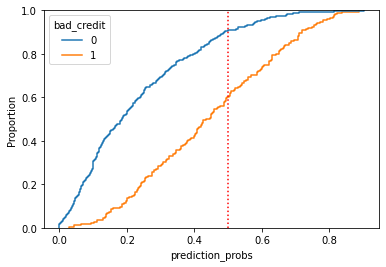

In [22]:
ax = sns.ecdfplot(x='prediction_probs', hue='bad_credit', data=credit_data_train)
ax.axvline(0.5, color='red', linestyle='dotted')

> Examine the plot you have created. Given the threshold value, do you expect a large number of Type II errors and why?   
> **End of exercise.**

### Evaluating the model   

How can we evaluate the performance of a classifier model? As with any statistical or machine learning model there is no one metric which can be considered 'best'. We will consider only a few of the possibilities here.  

First, let us consider all the possible outcomes of the hypothesis test. 

 - True Positives (TP): We predicted bad credit and the credit is bad.
 - True Negatives (TN): We predicted good credit and the credit is good.
 - False Positives (FP): We predicted bad credit but the credit was good; a Type I error.
 - False Negatives (FN): We predicted good credit but the credit was bad; a Type II error.
 
For the Binomial case, we can lay these options out in a **truth table**, which is commonly called a **confusion matrix**:
 
 |  | Classified Positive | Classified Negative |
| ---- | :---: | :---: |
|Positive | TP | FN |  
|Negative | FP | TN |

Some commonly used metrics are computed directly from the foregoing quantities:

- **Accuracy** = (TP + TN) / (TP + FP + TN + FN)
- **Precision** = TP / (TP + FP)
   - Precision is the correct fraction of the positive relevant class predictions.
- **Recall** = TP / (TP + FN)
   - Recall is the correct fraction of the relevant positive class members predicted.
- **F1** = $\frac{2\ precision\ recall}{precision + recall}$ = $\frac{TP}{TP + 1/2(FP +FN)}$      
   - Is the **harmonic mean** between precision and recall. In other words, a statistic which trades-offs precision and recall. 
   
These metrics can be computed using the [sklearn.metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics) package. In this case we use some of the classification metrics. Now, execute the code in the cell below to display performance metrics for the classifier model using the training data.    

In [23]:
def print_metrics(df):
    labels = df.loc[:,'credit_actual']
    scores = df.loc[:,'predicted_credit']
    metrics = sklm.precision_recall_fscore_support(labels, scores)
    conf = sklm.confusion_matrix(labels, scores)
    print('                 Confusion matrix')
    print('                 Score positive    Score negative')
    print('Actual positive    %6d' % conf[0,0] + '             %5d' % conf[0,1])
    print('Actual negative    %6d' % conf[1,0] + '             %5d' % conf[1,1])
    print('')
    print('Accuracy  %0.2f' % sklm.accuracy_score(labels, scores))
    print(' ')
    print('           Positive      Negative')
    print('Num case   %6d' % metrics[3][0] + '        %6d' % metrics[3][1])
    print('Precision  %6.2f' % metrics[0][0] + '        %6.2f' % metrics[0][1])
    print('Recall     %6.2f' % metrics[1][0] + '        %6.2f' % metrics[1][1])
    print('F1         %6.2f' % metrics[2][0] + '        %6.2f' % metrics[2][1])
    
print_metrics(credit_data_train) 

                 Confusion matrix
                 Score positive    Score negative
Actual positive        70               106
Actual negative        39               385

Accuracy  0.76
 
           Positive      Negative
Num case      176           424
Precision    0.64          0.78
Recall       0.40          0.91
F1           0.49          0.84


C:\USERS\STEVEPC2\ANACONDA3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Examine these metrics which can be interpreted as follows:   
1. A perfect classifier would produce a confusion matrix with entries only on the diagonal; no errors. In this case, there are significant errors. The number of false positives compared to the total number of positives is relatively low. However, fewer that half of the positive cases have been correctly classified.    
2. The overall accuracy of the model is reasonable.  
3. However, the recall statistic shows a significant problem with the model. The positive case recall is only 0.40, consistent with the low fraction of the correctly classified positive cases.   
4. Likewise, the precision is lower for positive cases as well.     

In summary, the initial classifier model is ding a poor job of detecting bad credit cases. In part, this performance results from the imbalance between the number of positive and negative cases in the data set.    

The evaluation of the model based on training data is undoubtedly biased, since this data was used to fit the model. Using the **held-back test data** is a more objective approach to model evaluation. Execute the code in the cell below to evaluated the model using the test data.       

In [24]:
credit_data_test = score_model(credit_data_test, glm_model, threshold)
print_metrics(credit_data_test) 

                 Confusion matrix
                 Score positive    Score negative
Actual positive        37                87
Actual negative        30               246

Accuracy  0.71
 
           Positive      Negative
Num case      124           276
Precision    0.55          0.74
Recall       0.30          0.89
F1           0.39          0.81


Overall, these results are consistent with those obtained using the training data. However, the results obtained with the test data are a bit worse than for the training data. This is expected, since the test data are a random sample of the original data.   

### Finding a better threshold

The forgoing results are not good. Since the choice of threshold was arbitrary, it is likely that another choice could yield better results. A hyperparameter search could find a threshold producing a better result.    

The question is, which metric should be used to optimize model performance? Accuracy, can be misleading, particularly in cases with imbalanced label values. For this problem we will assume that the bank will be more concerned with identifying potential bad credit customers. These considerations make recall seem to be a reasonable metric. In this case we will use F1, since it trades-off precision and recall.        

> **Exercise 26-3:** The code in the cell below performs a hyperparameter search of the cutoff threshold measured using the F1 score for the positive cases. Execute this code and examine the chart displayed.      

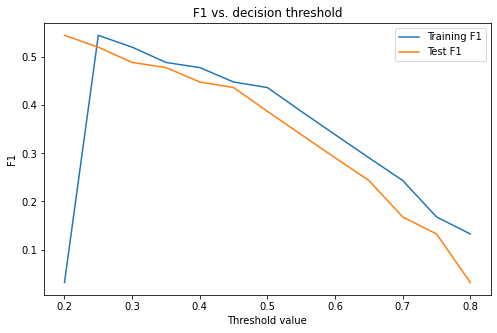

In [27]:
def threshold_test(model, df_train, df_test, thresholds, formula=formula):
    '''Function that tests accuracy of classifier for different threshold values'''
    accuracy_train = []
    accuracy_test = []
    for i,threshold in enumerate(thresholds):
        ## Compute the training accuracy
        df_train = score_model(df_train, model, threshold)
        accuracy_train.append(sklm.precision_recall_fscore_support(df_test.loc[:,'credit_actual'], df_test.loc[:,'predicted_credit'])[2][0])
        ## Then compute the test accuracy
        df_test = score_model(df_test, model, threshold)
        accuracy_test.append(sklm.precision_recall_fscore_support(df_test.loc[:,'credit_actual'], df_test.loc[:,'predicted_credit'])[2][0])      
    return accuracy_train, accuracy_test


def plot_thresholds(thresholds, accuracy_train, accuracy_test):
    fig, ax = plt.subplots(figsize=(8, 5)) # define axis  
    ax.plot(thresholds, accuracy_train, label='Training F1')
    ax.plot(thresholds, accuracy_test, label='Test F1')
    ax.set_ylabel('F1')
    ax.set_xlabel('Threshold value')
    ax.set_title('F1 vs. decision threshold')
    plt.legend()
    plt.show()
    
thresholds = np.arange(0.2, 0.8, step = 0.05)
accuracy_train, accuracy_test = threshold_test(glm_model, credit_data_train, credit_data_test, thresholds)
plot_thresholds(thresholds, accuracy_train, accuracy_test)    

> Examine your plot. What does the decreasing F1 of the positive cases. What does this downward slope with threshold tell you about the trade-off between F1 and threshold. In particular, how is this trade-off dependent on the choice of solution to the problem at hand?    
> **End of exercise.**    

> **Exercise 26-4:** You will now test how the model evaluation changes with changing the threshold value to 0.35. While this choice is a bit arbitrary, the goal is to improve the performance at detecting positive cases at the expense of Type I errors with negative cases. Do the following:   
> 1. In the first cell below set the threshold value, then score the model and print the metrics using the training data.  
> 2. In the second cell below set the threshold value, then score the model and print the metrics using the test data.  

In [28]:
threshold=0.35
credit_data_train = score_model(credit_data_train, glm_model, threshold)
print_metrics(credit_data_train) 

                 Confusion matrix
                 Score positive    Score negative
Actual positive       113                63
Actual negative        99               325

Accuracy  0.73
 
           Positive      Negative
Num case      176           424
Precision    0.53          0.84
Recall       0.64          0.77
F1           0.58          0.80


C:\USERS\STEVEPC2\ANACONDA3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
credit_data_test = score_model(credit_data_test, glm_model, threshold)
print_metrics(credit_data_test) 

                 Confusion matrix
                 Score positive    Score negative
Actual positive        61                63
Actual negative        70               206

Accuracy  0.67
 
           Positive      Negative
Num case      124           276
Precision    0.47          0.77
Recall       0.49          0.75
F1           0.48          0.76


C:\USERS\STEVEPC2\ANACONDA3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


> Compare the performance metrics for the training and testing data of the original threshold value of 0.5 with those of the updated threshold of 0.35.   
> 1. How have the errors shown in the confusion matrices changed?   
> 2. How have the recall and precision changed between the positive and negative cases changed and what does this tell you about the trade-off between Type I and Type II errors.  
> **End of exercise.**

For the testing data the plot below shows the probabilities computed for each of the classes using the testing data. This plot is the same type you created in Exercise 26-2.   

C:\USERS\STEVEPC2\ANACONDA3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


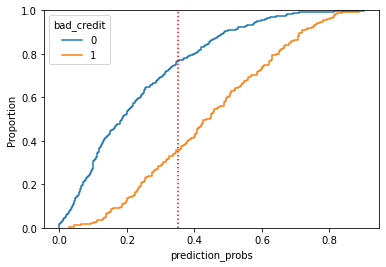

In [30]:
ax = sns.ecdfplot(x='prediction_probs', hue='bad_credit', data=credit_data_train) 
ax.axvline(0.35, color='red', linestyle='dotted')

Compare this plot the one created in Exercise 26-2. Notice how the number of Type II errors arising from the positive case curve will be lower, at the expense of Type I errors.  

### Applying regularization      

So far, we have been working with an over-fit model. Now we will explore the application of regularization to the model. The code in the cell below computes the training and test F1 statistics of the model as a function of the elastic net regularization parameter $\alpha$. The training and test F1 statistics are then plotted as a function of $\alpha$. Execute this code to execute the computation and display the plot.      

C:\USERS\STEVEPC2\ANACONDA3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


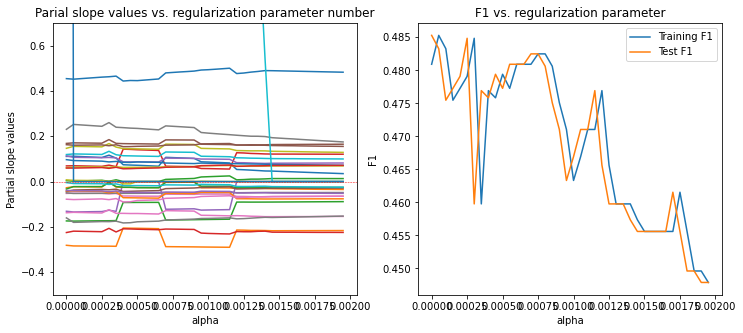

In [35]:
def regularized_coefs(df_train, df_test, alphas, n_coefs=31,
                      formula = formula, threshold=threshold):
    '''Function that computes a linear model for each value of the regualarization 
    parameter alpha and returns an array of the coefficient values. The L1_wt 
    determines the trade-off between L1 and L2 regualarization'''
    coefs = np.zeros((len(alphas),n_coefs + 1))
    accuracy_train = []
    accuracy_test = []
    for i,alpha in enumerate(alphas):
        ## First compute the training MSE
        #### Complete the line of code below
        temp_mod = smf.glm(formula, data=df_train).fit_regularized(method='elastic_net', alpha=alpha)
        ## Compute the training accuracy
        df_train = score_model(df_train, temp_mod, threshold)
        coefs[i,:] = temp_mod.params
        # accuracy_train.append(sklm.accuracy_score(df_test.loc[:,'credit_actual'], df_test.loc[:,'predicted_credit']))
        accuracy_train.append(sklm.precision_recall_fscore_support(df_test.loc[:,'credit_actual'], df_test.loc[:,'predicted_credit'])[2][0])
        ## Then compute the test accuracy
        df_test = score_model(df_test, temp_mod, threshold)
#        accuracy_test.append(sklm.accuracy_score(df_test.loc[:,'credit_actual'], df_test.loc[:,'predicted_credit'])) 
        accuracy_test.append(sklm.precision_recall_fscore_support(df_test.loc[:,'credit_actual'], df_test.loc[:,'predicted_credit'])[2][0])      
    return coefs, accuracy_train, accuracy_test


def plot_coefs(coefs, alphas, accuracy_train, accuracy_test, ylim=None):
    fig, ax = plt.subplots(1,2, figsize=(12, 5)) # define axis
    for i in range(coefs.shape[1]): # Iterate over coefficients
        ax[0].plot(alphas, coefs[:,i])
    ax[0].axhline(0.0, color='red', linestyle='--', linewidth=0.5)
    ax[0].set_ylabel('Partial slope values')
    ax[0].set_xlabel('alpha')
    ax[0].set_title('Parial slope values vs. regularization parameter number')
    if ylim is not None: ax[0].set_ylim(ylim)
    
    ax[1].plot(alphas, accuracy_train, label='Training F1')
    ax[1].plot(alphas, accuracy_test, label='Test F1')
    ax[1].set_ylabel('F1')
    ax[1].set_xlabel('alpha')
    ax[1].set_title('F1 vs. regularization parameter')
    plt.legend()
    plt.show()
    
    
    
threshold = 0.35
alphas = np.arange(0.0, 0.002, step = 0.00005)
#alphas = np.arange(0.0, 0.05, step = 0.0005)
Betas, accuracy_train, accuracy_test = regularized_coefs(credit_data_train, credit_data_test, alphas)
plot_coefs(Betas, alphas, accuracy_train, accuracy_test, ylim=[-0.5,0.7])    

> **Exercise 26-5:**

In [32]:
glm_model_regularized = smf.glm(formula, data=credit_data_train).fit_regularized(method='elastic_net', alpha=0.0006)
credit_data_train = score_model(credit_data_train, glm_model_regularized, threshold)
print_metrics(credit_data_train) 

C:\USERS\STEVEPC2\ANACONDA3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                 Confusion matrix
                 Score positive    Score negative
Actual positive       120                56
Actual negative       112               312

Accuracy  0.72
 
           Positive      Negative
Num case      176           424
Precision    0.52          0.85
Recall       0.68          0.74
F1           0.59          0.79


In [34]:
credit_data_test = score_model(credit_data_test, glm_model_regularized, threshold)
print_metrics(credit_data_test) 

                 Confusion matrix
                 Score positive    Score negative
Actual positive        63                61
Actual negative        75               201

Accuracy  0.66
 
           Positive      Negative
Num case      124           276
Precision    0.46          0.77
Recall       0.51          0.73
F1           0.48          0.75


> **Exercise 26-6:**

In [33]:
glm_model_regularized.params

C:\USERS\STEVEPC2\ANACONDA3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Intercept                                                       0.450441
C(credit_history)[T.critical account - other non-bank loans]   -0.207493
C(credit_history)[T.current loans paid]                        -0.092036
C(credit_history)[T.no credit - paid]                           0.138309
C(credit_history)[T.past payment delays]                        0.000000
C(purpose)[T.car (new)]                                         0.165919
C(purpose)[T.car (used)]                                       -0.142575
C(purpose)[T.domestic appliances]                               0.230394
C(purpose)[T.education]                                         0.143135
C(purpose)[T.furniture/equipment]                               0.111549
C(purpose)[T.other]                                             0.069040
C(purpose)[T.radio/television]                                 -0.026509
C(purpose)[T.repairs]                                          -0.027351
C(purpose)[T.retraining]                           

#### Copyright 2017, 2018, 2019, 2020, 2021 Stephen F Elston. All rights reserved. 